<a href="https://colab.research.google.com/github/rsadaphule/jhu-dnn/blob/main/Ravindra_Group15_%F0%9F%8F%86%F0%9F%92%8EDiamonds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>💎Diamonds</font>](https://www.kaggle.com/competitions/23may23jh-diamonds)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [130]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
!ls /content/drive/MyDrive/k*

/content/drive/MyDrive/kaggle.json


In [132]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
#!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 23may23jh-diamonds         # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

- competition is now set to: 23may23jh-diamonds
Using competition: 23may23jh-diamonds
  teamId  teamName           submissionDate       score       
--------  -----------------  -------------------  ----------  
10494527  Brian Yang         2023-06-05 04:19:32  612.98214   
10498626  Nana Wang          2023-06-05 00:08:38  622.51603   
10494477  Group 9            2023-06-04 18:28:17  651.65601   
10498310  JaneC              2023-06-05 01:54:10  672.00733   
10492997  Tony               2023-06-05 01:12:38  698.54751   
10431182  💎Baseline 🐍        2023-05-21 12:58:24  1066.56542  
10488713  Group 17           2023-06-01 01:43:58  1066.56542  
10488721  chriswells1184     2023-06-03 16:11:52  1066.56542  
10467571  Group 19           2023-06-04 19:35:09  1066.56542  
10468176  Group 15 - JHU     2023-06-04 05:30:07  1066.56542  
10502542  Group 10           2023-06-04 18:42:54  1066.56542  
10487654  Haoyan Zhang 2023  2023-06-04 20:14:10  1066.56542  
10493962  Larry Walker       202

In [133]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'trainXY/', 'testY/'

CPU times: user 1.26 s, sys: 86.6 ms, total: 1.34 s
Wall time: 1.96 s


In [134]:
df = pd.read_csv('XY_diamonds.csv'); df

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
199998,0.48,68.7,53.0,4.47,4.45,2.72,I,G,IF,1474.0
199999,0.48,65.0,64.7,5.60,5.62,3.44,I,H,VS2,765.0


# Lets analyze the data first

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   carat    200000 non-null  float64
 1   depth    200000 non-null  float64
 2   table    200000 non-null  float64
 3   x        200000 non-null  float64
 4   y        200000 non-null  float64
 5   z        200000 non-null  float64
 6   cut      200000 non-null  object 
 7   color    200000 non-null  object 
 8   clarity  200000 non-null  object 
 9   price    160000 non-null  float64
dtypes: float64(7), object(3)
memory usage: 15.3+ MB


In [136]:
df.describe()

,carat,depth,table,x,y,z,price
count,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,160000.00
mean,0.80,67.86,57.46,5.74,5.74,3.54,4487.57
...,...,...,...,...,...,...,...
75%,1.07,69.80,63.10,6.63,6.62,4.09,6160.25
max,5.76,87.80,96.10,11.79,65.41,27.67,23566.00


In [137]:
df.head()

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
3,0.28,67.9,60.3,4.30,4.26,2.66,P,E,VS2,NaN
4,0.34,67.5,69.4,5.44,5.50,3.32,P,E,VS2,NaN


## Lets check 0 and null values

In [138]:

print("Number of rows with x == 0: {} ".format((df.x==0).sum()))
print("Number of rows with y == 0: {} ".format((df.y==0).sum()))
print("Number of rows with z == 0: {} ".format((df.z==0).sum()))
print("Number of rows with depth == 0: {} ".format((df.depth==0).sum()))
print("Number of rows with carat == 0: {} ".format((df.carat==0).sum()))
print("Number of rows with table == 0: {} ".format((df.table==0).sum()))



Number of rows with x == 0: 30 
Number of rows with y == 0: 26 
Number of rows with z == 0: 83 
Number of rows with depth == 0: 0 
Number of rows with carat == 0: 0 
Number of rows with table == 0: 0 


In [139]:
df[df.isna().any(axis=1)]

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
39998,0.43,68.8,57.4,4.82,4.77,2.98,I,E,VS2,NaN
39999,1.36,65.5,53.7,6.57,6.53,4.10,P,H,SI2,NaN


In [140]:
print("Number of rows with x == null: {} ".format((df.x.isnull()).sum()))
print("Number of rows with y == null: {} ".format((df.y.isnull()).sum()))
print("Number of rows with z == null: {} ".format((df.z.isnull()).sum()))
print("Number of rows with depth == null: {} ".format((df.depth.isnull()).sum()))
print("Number of rows with carat == null: {} ".format((df.carat.isnull()).sum()))
print("Number of rows with cut == null: {} ".format((df.cut.isnull()).sum()))
print("Number of rows with clarity == null: {} ".format((df.clarity.isnull()).sum()))
print("Number of rows with price == null: {} ".format((df.price.isnull()).sum()))



Number of rows with x == null: 0 
Number of rows with y == null: 0 
Number of rows with z == null: 0 
Number of rows with depth == null: 0 
Number of rows with carat == null: 0 
Number of rows with cut == null: 0 
Number of rows with clarity == null: 0 
Number of rows with price == null: 40000 


All the feature columns looks ok. Price columns have 40,000 rows null. Lets eliminate these values


In [141]:
df.dropna(inplace=True)
df.isnull().sum()

carat      0
depth      0
          ..
clarity    0
price      0
Length: 10, dtype: int64

In [142]:
len(df)

160000

# Reduce Features
## Instead of using x, y, z as independent features, lets compute volume as one feature and eliminate x,y,z from the dataset. This will reduce number of fetures from 9 to 7


In [143]:
df['volume'] = df['x']*df['y']*df['z']
df.drop(['x', 'y', 'z'], axis=1, inplace=True)
df.head()

,carat,depth,table,cut,color,clarity,price,volume
40000,0.36,69.5,61.3,P,H,VS1,714.0,58.91
40001,0.87,70.7,56.3,I,G,VS2,7504.0,188.64
...,...,...,...,...,...,...,...,...
40003,0.30,69.6,69.8,P,D,VS2,923.0,81.49
40004,0.60,68.6,49.4,P,E,SI1,2873.0,71.01


In [144]:
len(df)

160000

#Lets look at Outliers

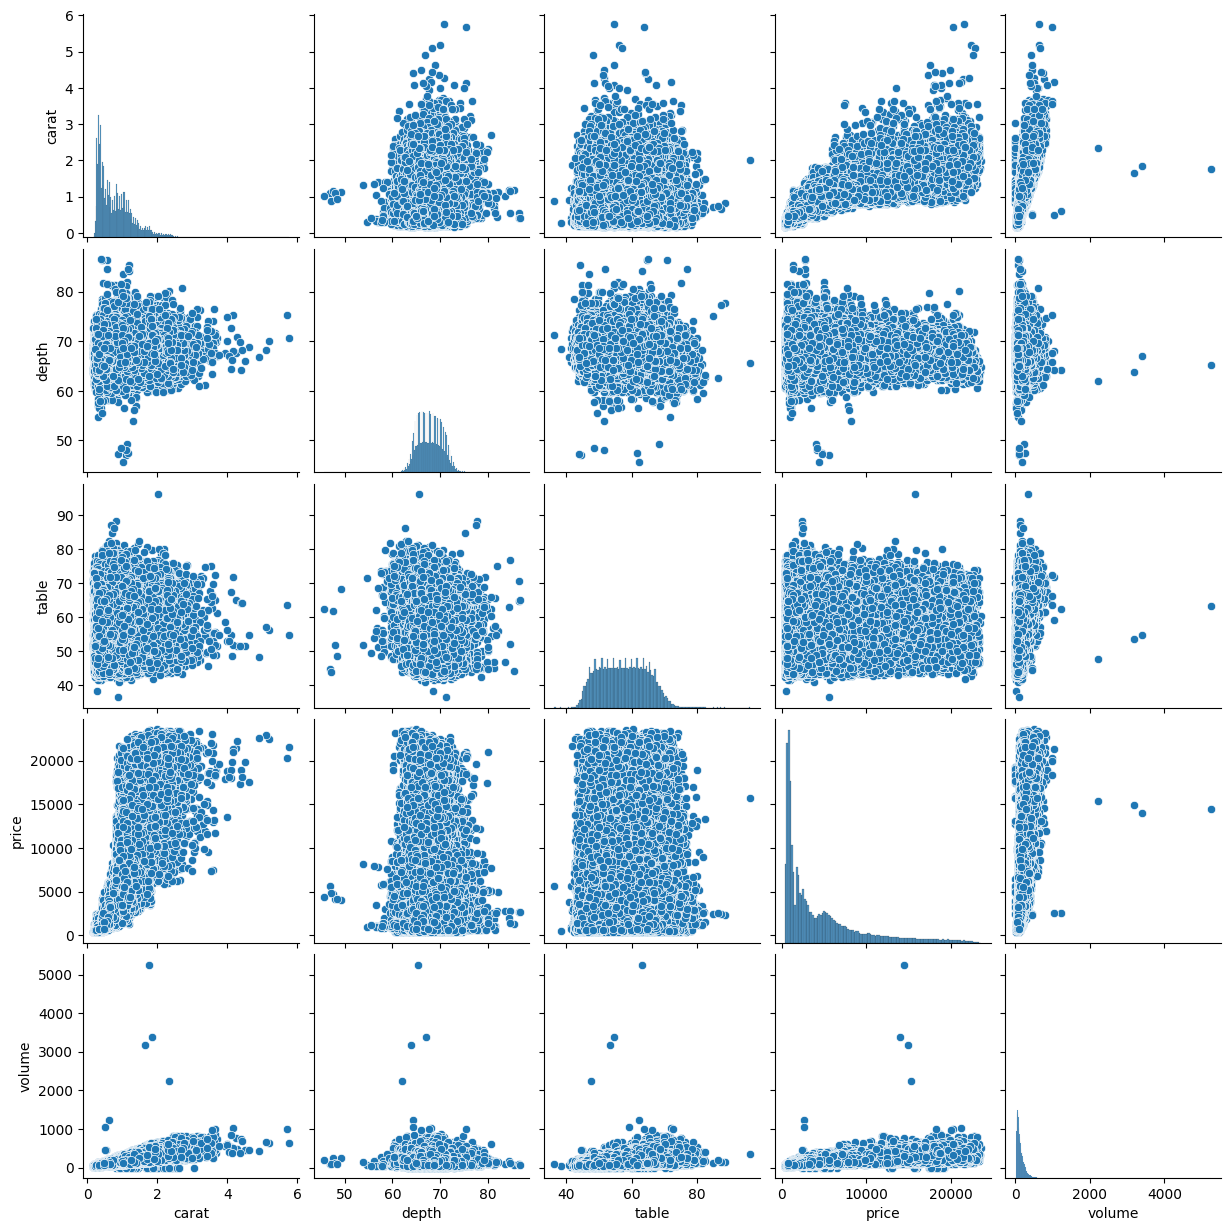

In [145]:
sns.pairplot(df)

carat        Axes(0.125,0.653529;0.227941x0.226471)
depth     Axes(0.398529,0.653529;0.227941x0.226471)
                            ...                    
price        Axes(0.125,0.381765;0.227941x0.226471)
volume    Axes(0.398529,0.381765;0.227941x0.226471)
Length: 5, dtype: object

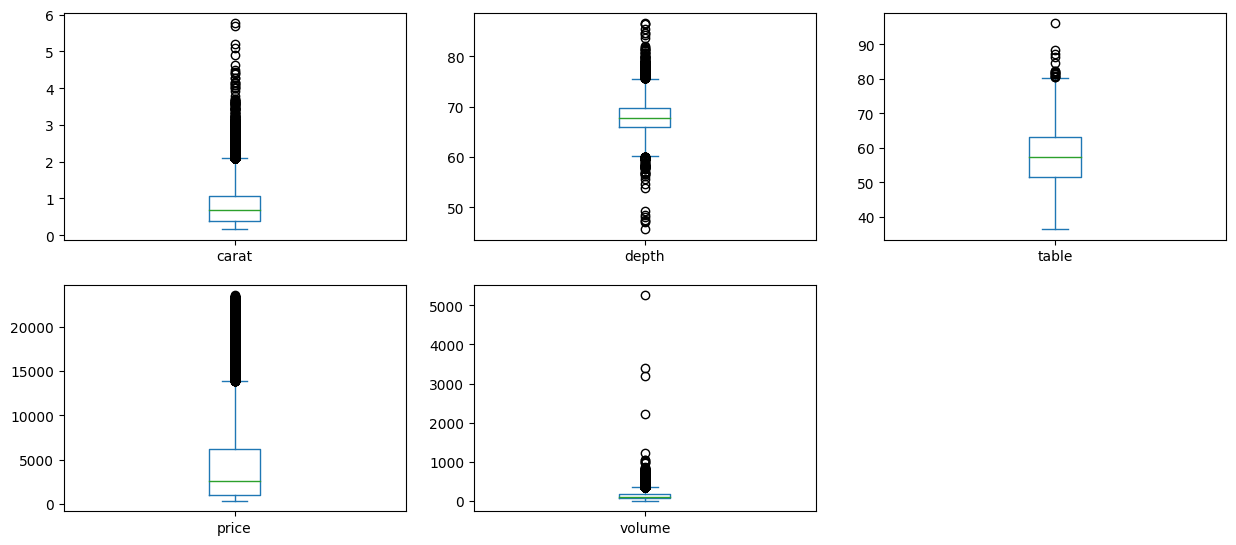

In [146]:
df.plot(kind='box',figsize=(15,10),subplots=True,layout=(3,3))
plt.show()

# Lets remove outliers by removing data ppints that lies outside Q1-1.5 IQR and Q3 + 1.5 IQR

In [147]:
def outliers(var):
    a = []
    q1 = df[var].quantile(.25)
    q2 = df[var].quantile(.5)
    q3 = df[var].quantile(.75)
    iqr = q3-q1
    ulim = float(q3+(1.5*iqr))
    llim = float(q1-(1.5*iqr))

    for i in df[var]:
        if i > ulim:
            i = np.NaN
        elif i < llim:
            i = np.NaN
        else:
            i=i
        a.append(i)
    return a

for col in df.select_dtypes(exclude='object').columns:
    df[col] = outliers(col)

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160000 entries, 40000 to 199999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   carat    156554 non-null  float64
 1   depth    159628 non-null  float64
 2   table    159984 non-null  float64
 3   cut      160000 non-null  object 
 4   color    160000 non-null  object 
 5   clarity  160000 non-null  object 
 6   price    149388 non-null  float64
 7   volume   153939 non-null  float64
dtypes: float64(5), object(3)
memory usage: 11.0+ MB


# Lets fill outliers with mean values

In [149]:
for i in df.select_dtypes(exclude='object').columns:
    df[i] = df[i].fillna(df[i].mean())

In [150]:
df.isnull().sum()

carat     0
depth     0
         ..
price     0
volume    0
Length: 8, dtype: int64

In [151]:
df.head()

,carat,depth,table,cut,color,clarity,price,volume
40000,0.36,69.5,61.3,P,H,VS1,714.0,58.91
40001,0.87,70.7,56.3,I,G,VS2,7504.0,188.64
...,...,...,...,...,...,...,...,...
40003,0.30,69.6,69.8,P,D,VS2,923.0,81.49
40004,0.60,68.6,49.4,P,E,SI1,2873.0,71.01


#Lets look at the data visually

<Axes: xlabel='volume', ylabel='price'>

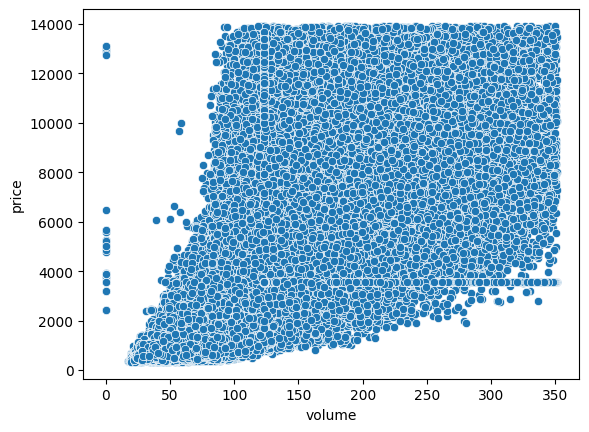

In [152]:
sns.scatterplot(data=df, x=df['volume'], y=df['price'])

# Lets at Categorical data and encode it

In [153]:
numerical_cols = df.select_dtypes(include=np.number).columns.to_list()
categorical_cols = df.select_dtypes(exclude=np.number).columns.to_list()

In [154]:
numerical_cols

['carat', 'depth', 'table', 'price', 'volume']

In [155]:
categorical_cols

['cut', 'color', 'clarity']

In [156]:
df['cut'].value_counts()

I    63854
P    41011
     ...  
G    14572
F     4777
Name: cut, Length: 5, dtype: int64

In [157]:
df['color'].value_counts()

G    33766
E    29180
     ...  
I    16150
J     8204
Name: color, Length: 7, dtype: int64

In [158]:
df['clarity'].value_counts()

SI1    39005
VS2    36314
       ...  
IF      5344
I1      2300
Name: clarity, Length: 8, dtype: int64

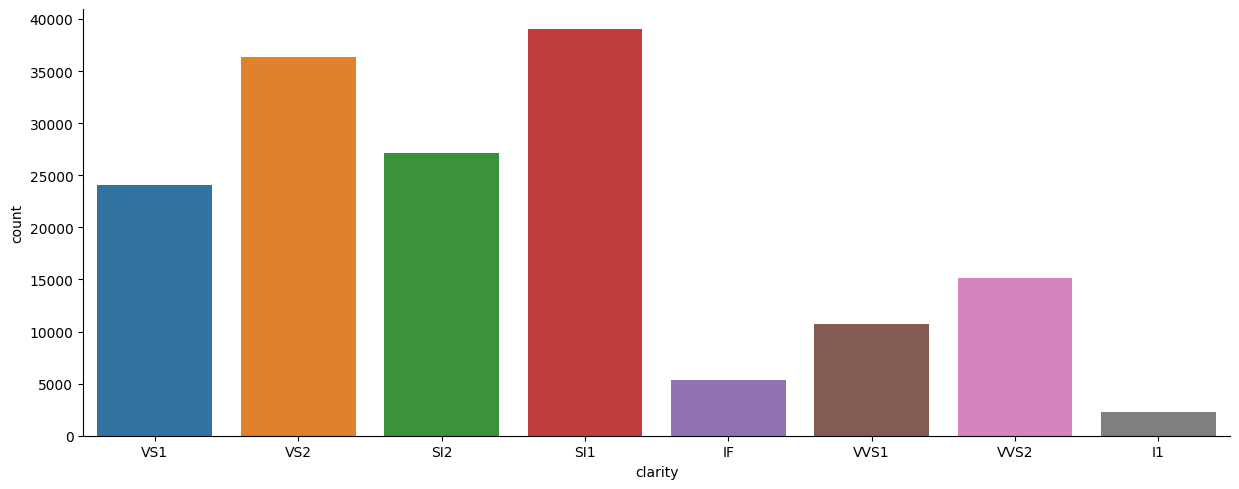

In [159]:
sns.catplot(data=df, x='clarity', kind='count', aspect=2.5)

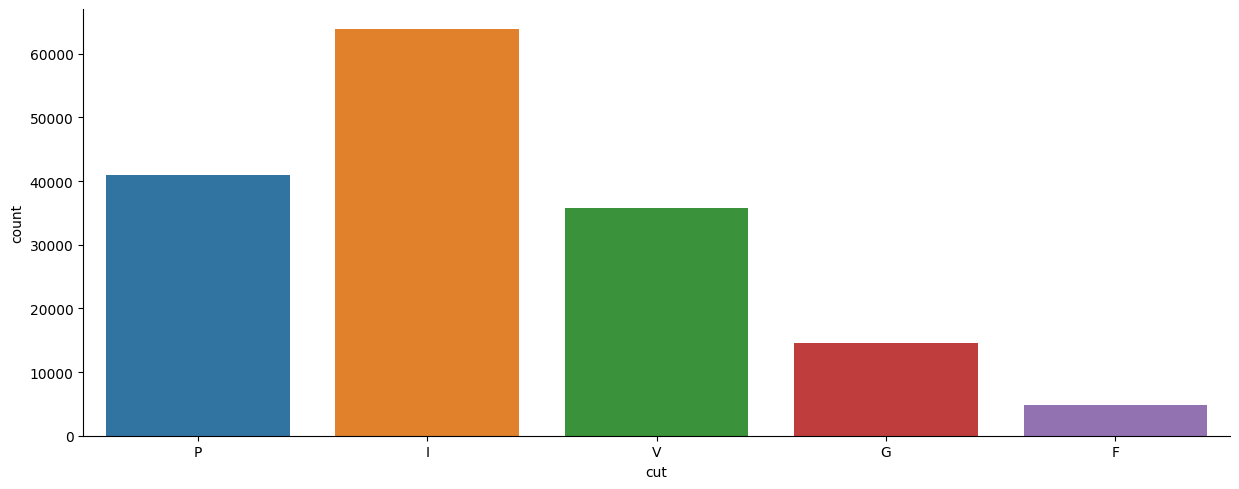

In [160]:
sns.catplot(data=df, x='cut', kind='count', aspect=2.5)

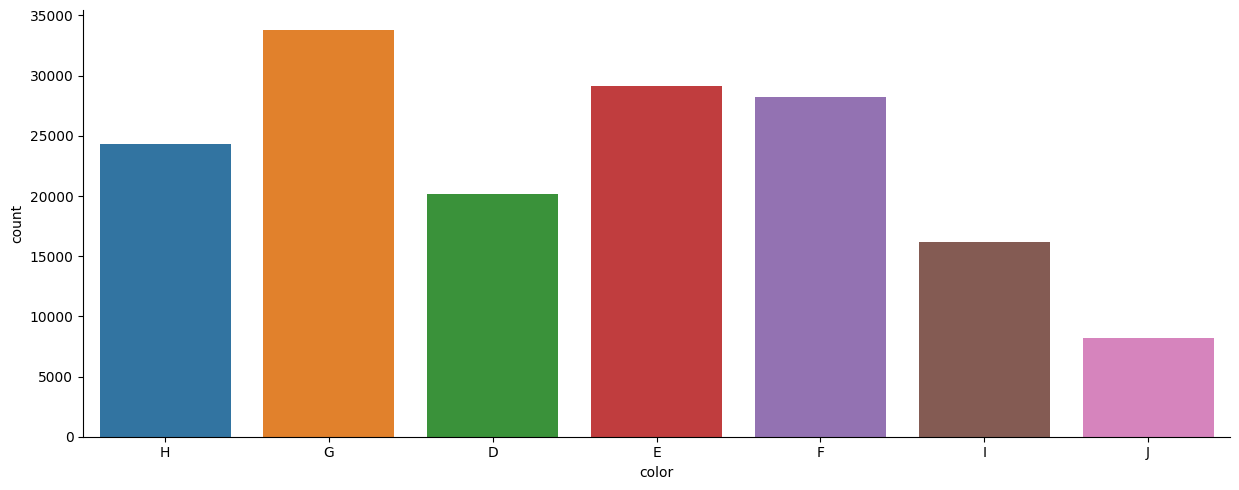

In [161]:
sns.catplot(data=df, x='color', kind='count', aspect=2.5)

# Lets encode categorical data

In [162]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 

df['cut'] = label_encoder.fit_transform(df['cut'])
df['color'] = label_encoder.fit_transform(df['color'])
df['clarity'] = label_encoder.fit_transform(df['clarity'])
df.head()

,carat,depth,table,cut,color,clarity,price,volume
40000,0.36,69.5,61.3,3,4,4,714.0,58.91
40001,0.87,70.7,56.3,2,3,5,7504.0,188.64
...,...,...,...,...,...,...,...,...
40003,0.30,69.6,69.8,3,0,5,923.0,81.49
40004,0.60,68.6,49.4,3,1,2,2873.0,71.01


# Separate Features and Label 

In [163]:
vX = df.query('price!=price').drop('price', axis=1)  # slice a test sample
tXY = df.query('price==price')                       # slice training sample
X, Y = tXY.drop('price', axis=1), tXY.price        # split into training I/O

# Split the data into training (80%) and test (20%)

In [164]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from numpy import mean, std



In [165]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

# ScatterCorrHist(tXY.head(200))  # takes a minute time to run

In [166]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**
 
1. Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc. 
1. Why did you choose these elements? (Perhaps something in EDA or prior experience lead you to these)
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

In [167]:
# Split data into training and validation sets
tX, vX, tY, vY = train_test_split(X, Y, test_size=0.3, random_state=42)

In [168]:
tX.shape

(112000, 7)

In [169]:
tY.shape

(112000,)

In [170]:
vX.shape

(48000, 7)

In [171]:
vY.shape

(48000,)

**Student's answer:**
I have tried following
* Checked Nan Vaues and Removed NaN values from the dataset
* Converted Categorical Input into Numeric Labels
* Combined x.y,z into one features there by reducing number of  features from 9 to 7

## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful. 

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**

# Improving Model Accuracy

## Feature Scaling:
Given that I'm using Polynomial Features with Linear Regression, it's crucial for me to normalize or standardize my features. This necessity arises from the fact that polynomial features create interaction terms and square values of the original features, consequently increasing the magnitude of these features. This could potentially lead to a situation where certain features dominate the model. I have used StandardScalar() to normalize the features.

## Model Selection:
The complexity of my problem may demand a model more sophisticated than a simple linear regression. For instance, if I'm dealing with high-dimensional data, I could consider employing models such as Ridge, Lasso or ElasticNet. Alternatively, if I suspect that the relationships in my data are not linear, non-linear models such as decision trees, random forests, or gradient boosting could be more suitable.
I have tried with Ridge models and RandomForest Model.

## Hyperparameter Tuning:
Given my use of Polynomial Features with Linear Regression, my scope for hyperparameter tuning might be somewhat limited since linear regression doesn't have hyperparameters in the conventional sense. However, if I were to switch to a different model (like those I mentioned earlier), I could fine-tune those hyperparameters using techniques like Grid Search or Random Search.

I have tried to vary degrees of Polynomiala from 2 to 4 and alpha parametes of Riddge Regression from 0.01 to 1. 
I found that I get best Performance (lowest rmse) when for degrees=4 and alpha to 0.01




In [172]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split data into training and validation sets
tX, vX, tY, vY = train_test_split(X, Y, test_size=0.3, random_state=42)



Below is a baseline model that produces the result on Kaggle leaderboard (LB).

In [173]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
tX0 = tX   # subsample for experimentation
tY0 = tY   # subsample for experimentation

poly = PolynomialFeatures(degree=2)
tX0_in = poly.fit_transform(tX0.select_dtypes(include=np.number))
vX_in = poly.transform(vX.select_dtypes(include=np.number))
m = LinearRegression()
m.fit(tX0_in, tY0)

LinearRegression()

In [174]:
vY_pred = m.predict(vX_in)
# Calculate the Mean Squared Error
mse = mean_squared_error(vY, vY_pred)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mse)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(vY, vY_pred)

# Calculate the R-squared score
r2 = r2_score(vY, vY_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared Score: {r2}")

Mean Squared Error (MSE): 3147134.694711076
Root Mean Squared Error (RMSE): 1774.0165429643198
Mean Absolute Error (MAE): 1167.8657021783984
R-squared Score: 0.67870340811697


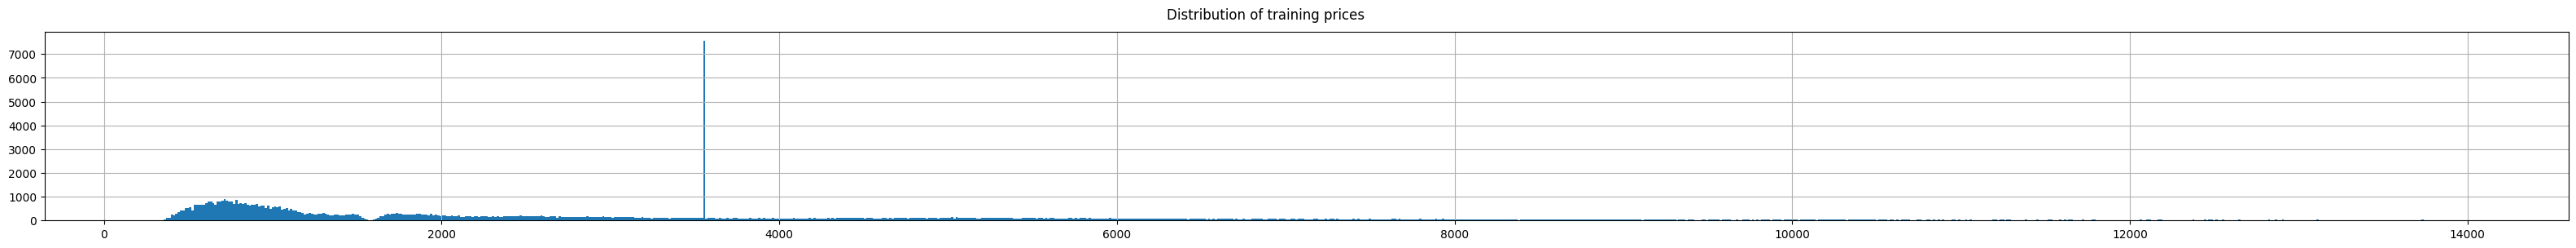

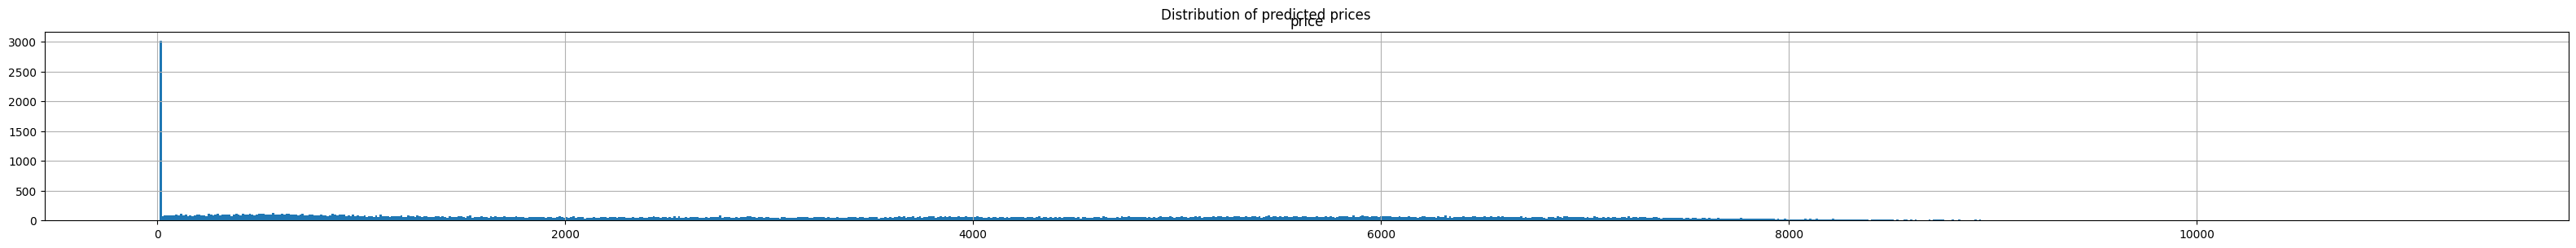

In [175]:
pY = pd.DataFrame(m.predict(vX_in), index=range(1,len(vX_in)+1), columns=['price'])  # ensure that labels and observations are in corresponding order
pY = pY.clip(lower=10)  # ensures no negative prices
_ = tY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of training prices");
_ = pY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of predicted prices");
ToCSV(pY, '💎Baseline')

# Lets improve over baseline with GridSearch for Ridge Regression

In [176]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline - Polynomial Features, StandardScaler, Ridge Regression
pipe = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    StandardScaler(), 
    Ridge()
)

# Parameter grid for GridSearchCV
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Grid search with cross-validation
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)

# Select only numeric features
tX0_numeric = tX0.select_dtypes(include=np.number)
vX_numeric = vX.select_dtypes(include=np.number)

grid.fit(tX0_numeric, tY0)

print("Best parameters: ", grid.best_params_)
print("Best cross-validation score: ", grid.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False)),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             verbose=1)

Best parameters:  {'ridge__alpha': 1}
Best cross-validation score:  0.6786756958573029


In [177]:
# Make predictions using the model with the best parameters
vY_pred = grid.best_estimator_.predict(vX_numeric)

In [178]:

# Calculate the Mean Squared Error
mse = mean_squared_error(vY, vY_pred)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mse)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(vY, vY_pred)

# Calculate the R-squared score
r2 = r2_score(vY, vY_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared Score: {r2}")

Mean Squared Error (MSE): 3147071.054884627
Root Mean Squared Error (RMSE): 1773.998606223981
Mean Absolute Error (MAE): 1167.853111785485
R-squared Score: 0.678709905220313


In [179]:
vX_numeric.shape

(48000, 7)

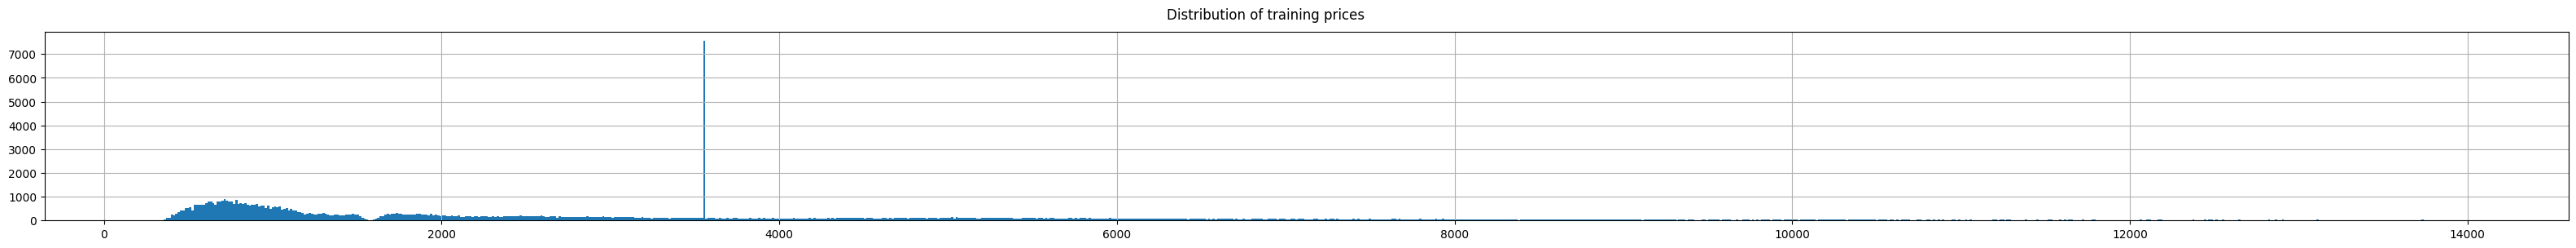

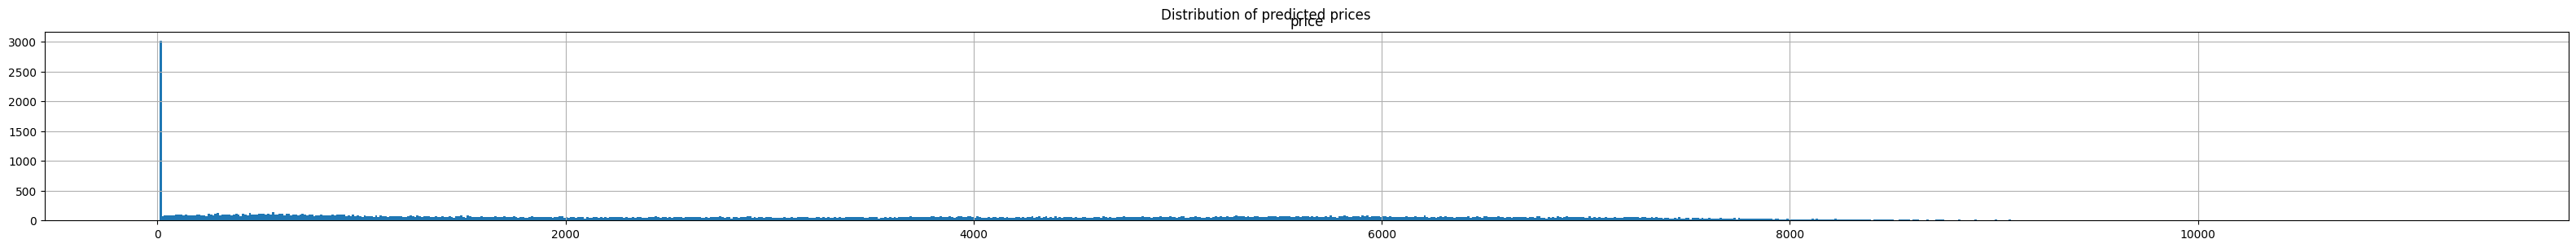

In [180]:
pY = pd.DataFrame(grid.best_estimator_.predict(vX_numeric), index=range(1,len(vX_numeric)+1), columns=['price'])  # ensure that labels and observations are in corresponding order
pY = pY.clip(lower=10)  # ensures no negative prices
_ = tY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of training prices");
_ = pY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of predicted prices");
ToCSV(pY, 'Group15-June04-2023')

# Lets improve over baseline using Ensemble model like RandomForestRegressor

In [181]:
from sklearn.ensemble import RandomForestRegressor
m  = RandomForestRegressor()
m.fit(tX,tY)
y_pred = m.predict(vX)




# Calculate the Mean Squared Error
mse = mean_squared_error(vY, y_pred)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mse)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(vY, y_pred)

# Calculate the R-squared score
r2 = r2_score(vY, y_pred)




RandomForestRegressor()

In [182]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared Score: {r2}")

Mean Squared Error (MSE): 1724519.3232315937
Root Mean Squared Error (RMSE): 1313.2095503885105
Mean Absolute Error (MAE): 663.7643722171081
R-squared Score: 0.8239407477150869


# RMSE has come down Drastically.


#Lets find best parameters using GridSearcchCV

In [184]:
n_estimators = [int(x) for x in np.linspace(10,200,10)]
max_depth = [int(x) for x in np.linspace(10,100,10)]
min_samples_split = [2,3,4,5,10]
min_samples_leaf = [1,2,4,10,15,20]
random_grid = {'n_estimators':n_estimators,'max_depth':max_depth,
               'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

random_grid

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': [2, 3, 4, 5, 10],
 'min_samples_leaf': [1, 2, 4, 10, 15, 20]}

In [187]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               cv = 3)

rf_random.fit(tX,tY)
y_pred = rf_random.predict(vX)

print("RMSE: {}".format(np.sqrt(mean_squared_error((vY),(y_pred)))))
print("R2  : {}".format(np.sqrt(r2_score((vY),(y_pred)))))

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'min_samples_leaf': [1, 2, 4, 10, 15,
                                                             20],
                                        'min_samples_split': [2, 3, 4, 5, 10],
                                        'n_estimators': [10, 31, 52, 73, 94,
                                                         115, 136, 157, 178,
                                                         200]})

RMSE: 1306.842385162792
R2  : 0.9086494779776888


In [188]:
rf_random.best_params_

{'n_estimators': 136,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_depth': 100}

In [189]:
rf = RandomForestRegressor(n_estimators=73,
                         min_samples_split=3,
                         min_samples_leaf=4,
                         max_depth=40)
rf.fit(tX,tY)
y_pred = rf.predict(vX)

print("RMSE: {}".format(np.sqrt(mean_squared_error((vY),(y_pred)))))
print("R2  : {}".format(np.sqrt(r2_score((vY),(y_pred)))))

RandomForestRegressor(max_depth=40, min_samples_leaf=4, min_samples_split=3,
                      n_estimators=73)

RMSE: 1312.0613032151423
R2  : 0.907881324455021


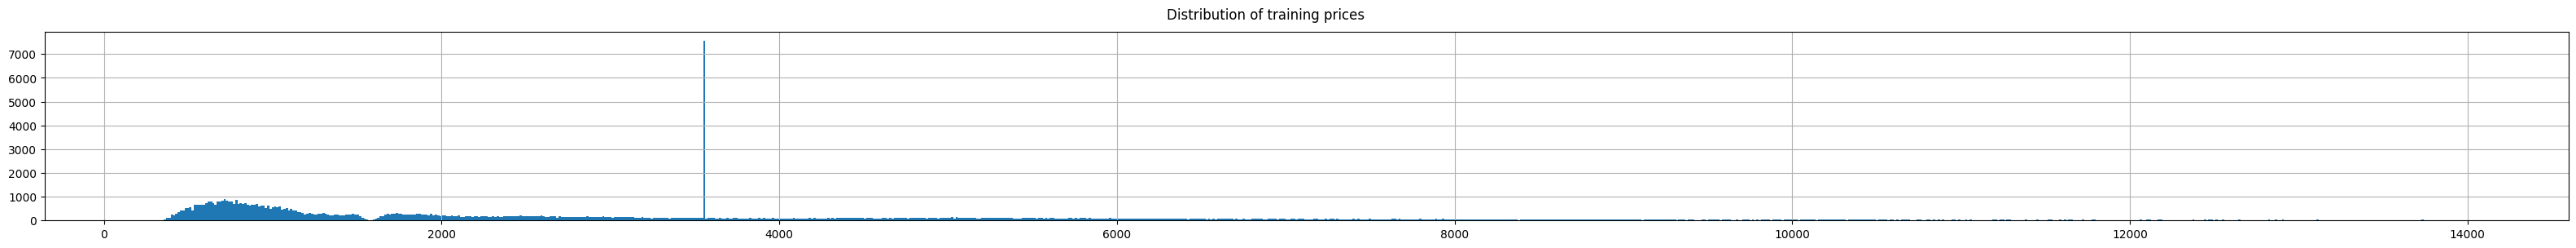

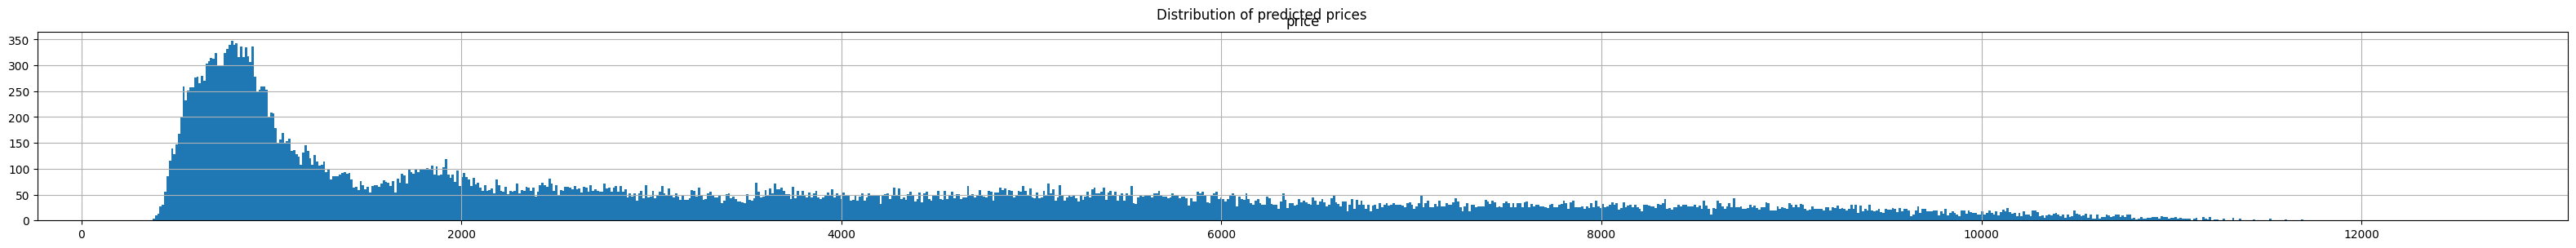

In [190]:
pY = pd.DataFrame(y_pred, index=range(1,len(vX)+1), columns=['price'])  # ensure that labels and observations are in corresponding order
pY = pY.clip(lower=10)  # ensures no negative prices
_ = tY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of training prices");
_ = pY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of predicted prices");
ToCSV(pY, 'Group15-June04-2023-02')

In [191]:
len(pY)

48000

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [183]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 85 sec > 60 sec limit!!!


# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).

## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features (investigate scatterplot matrix)
1. Try higher order feature interactions ($x_i^a$, $x_ix_j$, ...) to identify new key features or their linear combinations. With too many features you can use a smaller subsample or reduce dimensionality of feature space using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), or [UMAP](https://umap-learn.readthedocs.io/en/latest/).
1. Do a thorough EDA and understand non-linear relation in I/O. Are any interactions more special than others (E.g. is diamond *volume* a better predictor?)
1. If you note a shift in trend for any predictors, try building a model for each trend.
1. Evaluate predictions and focus on poorly predicted "groups". Can they be identified and modeled separately?
1. Do scatter plots show piecewise linear shape? Can a separate linear model be used on each support of approximately linear X-Y relation?
1. How are categorical features treated by the SKLearn models? Is there a [better way](https://www.google.com/search?q=ways+to+encode+categorical+data) to encode these (perhaps, ordinal) features? 
  1. E.g. you could replace codes (or groups of codes) with their frequencies, which may capture the implied "distance" or rarity between category levels.
  1. If encoding ordinal features with integers, should non-equidistant values be considered?
1. Learn about [modeling price of a diamond](https://www.google.com/search?q=machine+learning+model+price+diamond).
1. Try post-processing: shifting/scaling/transforming the distribution of predicted prices `pY` to match the distribution of training prices `tY`
